In [1]:
import numpy as np
import os, sys
import h5py
import pandas as pd
import matplotlib.pyplot as plt

import datetime as DT
import matplotlib.dates as mdates

sys.path.append('/Users/ajc/Core/SimDataInputs/ats-repo/ats-Aug6/tools/utils/')
sys.path.append('/Users/ajc/Core/PostProcessData/PyScript')
sys.path.append('/Users/ajc/Core/PostProcessData/PyScript/barrow')

import readdata as rd
import plot_water_table2D
sys.path.append(os.getcwd())
import SiteC_2012_2014WL 

import importlib as imp

In [2]:
time_origin = DT.datetime(2010,1,1,0,0,0)

In [3]:
imp.reload(SiteC_2012_2014WL)

data2012 = SiteC_2012_2014WL.getData_2012()

In [4]:
imp.reload(SiteC_2012_2014WL)
ObservedData2013 = dict()
data2013 = SiteC_2012_2014WL.getData_2013()

In [5]:
imp.reload(SiteC_2012_2014WL)
ObservedData2014 = dict()
data2014 = SiteC_2012_2014WL.getData_2014()

In [6]:
imp.reload(SiteC_2012_2014WL)
dataPrecip = SiteC_2012_2014WL.getDataRain()

In [7]:

dataPrecip['Rain'] = np.concatenate((dataPrecip['rain_2012'], dataPrecip['rain_2013'], dataPrecip['rain_2014']))
dataPrecip['Time'] = np.concatenate((dataPrecip['time_2012'], dataPrecip['time_2013'], dataPrecip['time_2014']))
dataPrecip['Time'] = np.array([2010 + t/365. for t in dataPrecip['Time']])

In [8]:
ObservedData2012 = dict()
ObservedData2013 = dict()
ObservedData2014 = dict()

for key in list(data2013):#.keys():
    ObservedData2012[key] = data2012[key]
    ObservedData2013[key] = data2013[key]
    ObservedData2014[key] = data2014[key]
Z_c = 4.78591
Z_t = 4.71264

In [9]:
# correcting the elevation of the center
def OffsetData():
    for key in list(ObservedData2012):#.keys():
        if 'water_level_C40' in key:
            ObservedData2012[key + '_offset'] = np.array([d - 4.91 + Z_c for d in ObservedData2012[key]])
    for key in list(ObservedData2012):#.keys():
        if 'water_level_C39' in key:
            ObservedData2012[key + '_offset'] = np.array([d - 4.81 + Z_c for d in ObservedData2012[key]])
    for key in list(ObservedData2013):#.keys():
        if 'water_level_C39' in key:
            ObservedData2013[key + '_offset'] = np.array([d - 4.81 + Z_c for d in ObservedData2013[key]])
    for key in list(ObservedData2014):#.keys():
        if 'water_level_C39' in key:
            ObservedData2014[key + '_offset'] = np.array([d - 4.81 + Z_c for d in ObservedData2014[key]])
    #print ObservedData2012['water_level_C40_offset'].shape
OffsetData()

#--- Remove the assigned 100 to the missing data points

alpha1, alpha2 = 1, 0
LC39 = len(ObservedData2012['water_level_C39_offset'])
mask = np.ones(LC39, dtype=bool)

for i,d1 in enumerate(ObservedData2012['water_level_C39_offset']):
    if d1 > 10:
        mask[i] = False

ObservedData2012['water_level_C39_mask'] = ObservedData2012['water_level_C39_offset'][mask]
ObservedData2012['time_C39_mask'] = ObservedData2012['time_C39'][mask]

#-----------------------------------------------------------------


# Average the data at the two center wells
assert len(ObservedData2012['water_level_C39']) == len(ObservedData2012['water_level_C40_offset'])
data = []
index = np.where(ObservedData2012['water_level_C39_offset'] > 10)[0]

mid_value = 0.5*(ObservedData2012['water_level_C39_offset'][index[0]-1] + ObservedData2012['water_level_C39_offset'][index[-1]+1])

for d1,d2 in zip(ObservedData2012['water_level_C39_offset'], ObservedData2012['water_level_C40_offset']):
    sum = 0
    if d1 < 10:
        sum = 0.5*(d1+d2)
    else:
        sum = 0.5*(d2 + mid_value)
    data.append(sum)
#data = ObservedData2012['water_level_C40_offset']
ObservedData2012['water_level_Center_offset'] = np.array(data)#np.concatenate(data)

#print len(ObservedData2013['water_level_C39_offset']), len(ObservedData2013['water_level_C40'])

data = []
c = 0
for i in range(len(ObservedData2013['water_level_C39_offset'])):
    if i <7:
        data.append(ObservedData2013['water_level_C39_offset'][i])
    elif (i < 113):
        sum = alpha1*(ObservedData2013['water_level_C39_offset'][i] + alpha2*ObservedData2013['water_level_C40'][i-7])    
        data.append(sum)
    else:
        data.append(ObservedData2013['water_level_C39_offset'][i])


ObservedData2013['water_level_Center'] = np.array(data) #np.concatenate(data)

#--- 2014
#print len(ObservedData2014['water_level_C39']), len(ObservedData2014['water_level_C40'])
data = []
for i in range(len(ObservedData2014['water_level_C39_offset'])):
        sum = alpha1*(ObservedData2014['water_level_C39_offset'][i] + alpha2*ObservedData2014['water_level_C40'][i])    
        data.append(sum)

ObservedData2014['water_level_Center'] = np.array(data)#np.concatenate(data)

for key in list(ObservedData2012):#.keys():
    if 'time' in key:
        ObservedData2012[key + '_yr'] =  np.array([2010 + t/365.0 for t in ObservedData2012[key]])
for key in list(ObservedData2013):#.keys():
    if 'time' in key:
        ObservedData2013[key + '_yr'] =  np.array([2010 + t/365.0 for t in ObservedData2013[key]])

for key in list(ObservedData2014):#.keys():
    if 'time' in key and 'yr' not in key:
        ObservedData2014[key + '_yr'] =  np.array([2010 + t/365.0 for t in ObservedData2014[key]])


In [10]:
import re
def sorted_nicely( l ):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [11]:
simulation_soil = ['SiteC_3D_3R1C', 'SiteC_3D_3R3A','SiteC_3D_3R3C'] # bare soil evaporation case
simulation_cond = ['SiteC_3D_3R1C', 'SiteC_3D_3R4A','SiteC_3D_3R4B'] # hydraulic conductivities case
simulation_null = ['SiteC_3D_3R5A','SiteC_3D_3R5B'] # hydraulic conductivities case
SimName = ['S0','S1', 'S2']
path = "/Users/ajc/Core/Projects/ATS-Data/OR-CONDO/simulations/barrow_icewedges/NGEE/SiteC_3D_June10/"
path_null = "/Users/ajc/Core/Projects/ATS-Data/OR-CONDO/simulations/barrow_icewedges/NGEE/SiteC_3D_210120/"

dir_files = os.listdir(path + simulation_soil[0])
Vars = ['temperature-center', 'temperature-left-trough', 'ponded_depth-center', 'ponded_depth-lefttrough', 
        'saturation_gas-center','saturation_gas-left-trough']
Files = dict()
for var in Vars:
    Files_Temporary = [f for f in dir_files if f.startswith(var)]
    Files[var] = sorted_nicely(Files_Temporary)


In [47]:
DataSimAll_soil = dict()
DataSimAll_cond = dict()
DataSimAll_null = dict()
DataSim1 = dict()
DataSim2 = dict()
DataSim3 = dict()
time = dict()
temp_C = []
for i,sim in enumerate(simulation_soil):
    Sname = SimName[i] + '-'
    for var in Vars:
        for files in Files[var]:
            dat = rd.ReadSingleFile(os.path.join(path+sim,files))
            DataSimAll_soil[Sname + files[:-4]] = np.array(dat['data'])
            time1 = [t/86400 for t in dat['time']]
            time[SimName[i] + '_time'] = np.array(time1)

DataSim1['Time'] = time['S0_time']
DataSim2['Time'] = time['S1_time']
DataSim3['Time'] = time['S2_time']

for key in DataSimAll_soil.keys():
    if SimName[0] in key:
        DataSim1[key[3:]] = DataSimAll_soil[key]
    if SimName[1] in key:
        DataSim2[key[3:]] = DataSimAll_soil[key]
    if SimName[2] in key:
        DataSim3[key[3:]] = DataSimAll_soil[key]

DataSim4 = dict()
DataSim5 = dict()
for i,sim in enumerate(simulation_cond):
    Sname = SimName[i] + '-'
    for var in Vars:
        for files in Files[var]:
            dat = rd.ReadSingleFile(os.path.join(path+sim,files))
            DataSimAll_cond[Sname + files[:-4]] = np.array(dat['data'])
            time1 = [t/86400 for t in dat['time']]
            time[SimName[i] + '_time'] = np.array(time1)
            
DataSim4['Time'] = time['S1_time']
DataSim5['Time'] = time['S2_time']
#print (DataSim5['Time'])
for key in DataSimAll_cond.keys():
    if SimName[1] in key:
        DataSim4[key[3:]] = DataSimAll_cond[key]
    if SimName[2] in key:
        DataSim5[key[3:]] = DataSimAll_cond[key]
        
        
#Null space
DataSim6 = dict()
DataSim7 = dict()
for i,sim in enumerate(simulation_null):
    Sname = SimName[i] + '-'
    for var in Vars:
        for files in Files[var]:
            dat = rd.ReadSingleFile(os.path.join(path_null+sim,files))
            DataSimAll_null[Sname + files[:-4]] = np.array(dat['data'])
            time1 = [t/86400 for t in dat['time']]
            time[SimName[i] + '_time'] = np.array(time1)
            
DataSim6['Time'] = time['S1_time']
DataSim7['Time'] = time['S2_time']
print (DataSim6.keys())
for key in DataSimAll_null.keys():
    if SimName[0] in key:
        DataSim6[key[3:]] = DataSimAll_null[key]
    if SimName[1] in key:
        DataSim7[key[3:]] = DataSimAll_null[key]
print (DataSim6.keys(), DataSim7.keys())

dict_keys(['Time'])
dict_keys(['Time', 'temperature-center-2cm', 'temperature-center-4cm', 'temperature-center-6cm', 'temperature-center-8cm', 'temperature-center-10cm', 'temperature-center-12cm', 'temperature-center-14cm', 'temperature-center-16cm', 'temperature-center-18cm', 'temperature-center-20cm', 'temperature-center-22cm', 'temperature-center-24cm', 'temperature-center-26cm', 'temperature-center-28cm', 'temperature-center-30cm', 'temperature-center-32cm', 'temperature-center-34cm', 'temperature-center-36cm', 'temperature-center-38cm', 'temperature-center-40cm', 'temperature-center-42cm', 'temperature-center-44cm', 'temperature-center-48cm', 'temperature-center-50cm', 'temperature-center-52cm', 'temperature-center-54cm', 'temperature-center-56cm', 'temperature-center-58cm', 'temperature-center-60cm', 'temperature-center-70cm', 'temperature-center-80cm', 'temperature-center-100cm', 'temperature-center-124cm', 'temperature-center-126cm', 'temperature-center-150cm', 'temperature-lef

In [48]:
def getTempAtdepths(DataSim,location = 'center', saturation='saturation_liquid'):
    dat_temp = []
    dat_sl = []
    K = ''
    
    for key in sorted_nicely(DataSim.keys()):
        
        if 'temperature' in key and location in key:
            K = key
            key_wt = saturation + key[key.find('-'):]
            if key_wt in DataSim.keys():
                dat_temp.append(DataSim[key])
                dat_sl.append(DataSim[key_wt])
    print ('GetTempDepths:', len(dat_temp), len(DataSim['Time']), len(dat_temp)*len(DataSim['Time']))
    
    temp_depth = np.reshape(dat_temp, (-1,len(DataSim['Time'])))
    sl_depth = np.reshape(dat_sl, (-1,len(DataSim['Time'])))
    return [temp_depth, sl_depth]

def getWaterTableUpdate(DataSim,location ='center',datum=0):
    depth = 0
    WaterTable = []
    WaterTableTime = []
    Surface_PD = []
    ThawDepth = []
    print ('WaterTableUp1: ', DataSim['Time'][:3])
    if 'center' in location:
        MicroLoc = 'center'
    elif 'trough' in location:
        MicroLoc = 'lefttrough'
    for key in sorted_nicely(DataSim.keys()):
        if 'temperature' in key and location in key:
            wt_above_ice_table = True
            depth = key[key.rfind('-')+1:-2]
            
            T_at_depth, S_at_depth = getTempAtdepths(DataSim, location,saturation='saturation_gas')
            
            for i in range(len(T_at_depth[0,:])):
                T_index = np.where(T_at_depth[:,i] > 273.15)[0]
                Surface_PD.append(DataSim['ponded_depth-%s'%MicroLoc][i])
                wt_position = -100
                
                if (Surface_PD[-1] > 0):
                    wt_position = 0
                elif len(T_index) > 0 and Surface_PD[-1] == 0:
                    for j in range(len(T_index)):
                        wt_position = j*0.02
                        if S_at_depth[j,i] == 0:
                            break
                        
                wt_position = wt_position if wt_position > 0 else 0
                
                thaw_index =  0.02 *(T_index[-1]+1) if len(T_index) > 0 else 0
                WaterTable.append(datum + Surface_PD[-1] - wt_position)
                WaterTableTime.append(DataSim['Time'][i])
                ThawDepth.append(datum - thaw_index)
            
            break
    
    return [WaterTableTime,WaterTable, ThawDepth]
            

In [49]:
def getSimulatedData(DataSim):
    WaterTableTimeCenter,WaterTableCenter,ThawDepthCenter = getWaterTableUpdate(DataSim,datum=Z_c)
    WaterTableTimeTrough,WaterTableTrough,ThawDepthTrough = getWaterTableUpdate(DataSim,'trough',datum=Z_t)
    DataSimulated = dict()
    DataSimulated['TimeCenter'] = [2010 + t/365. for t in WaterTableTimeCenter]
    DataSimulated['WL_center'] = WaterTableCenter
    DataSimulated['WL_trough'] = WaterTableTrough
    DataSimulated['TimeTrough'] = [2010 + t/365. for t in WaterTableTimeTrough]
    DataSimulated['TD_center'] = [t for t in ThawDepthCenter]
    DataSimulated['TD_trough'] = [t for t in ThawDepthTrough]

    Data_C = []
    Data_T = []
    Time_C = []
    Time_T = []
    print ('GetsimulatedData1: ', WaterTableTimeCenter[:3])
    for i,d in enumerate(DataSimulated['WL_center']):
        if d != 0:
            Data_C.append(d + Z_c*0)
            Time_C.append(DataSimulated['TimeCenter'][i])
    for i,d in enumerate(DataSimulated['WL_trough']):
        if d != 0:
            Data_T.append(d + Z_t*0)
            Time_T.append(DataSimulated['TimeTrough'][i])

    DataSimulated['water_level_center'] = np.array(Data_C)
    DataSimulated['water_level_trough'] = np.array(Data_T)
    DataSimulated['time_center'] = np.array(Time_C)
    DataSimulated['time_trough'] = np.array(Time_T)
    print ('GetsimulatedData: ', DataSimulated['time_center'][:3])
    return DataSimulated

In [51]:
DataSim1updated =  getSimulatedData(DataSim1)
DataSim2updated =  getSimulatedData(DataSim2)
DataSim3updated =  getSimulatedData(DataSim3)
DataSim4updated =  getSimulatedData(DataSim4)
DataSim5updated =  getSimulatedData(DataSim5)

DataSim6updated =  getSimulatedData(DataSim6)
DataSim7updated =  getSimulatedData(DataSim7)


WaterTableUp1:  [731. 732. 733.]
GetTempDepths: 29 1095 31755
WaterTableUp1:  [731. 732. 733.]
GetTempDepths: 30 1095 32850
GetsimulatedData1:  [731.0, 732.0, 733.0]
GetsimulatedData:  [2012.00273973 2012.00547945 2012.00821918]
WaterTableUp1:  [731. 732. 733.]
GetTempDepths: 29 1095 31755
WaterTableUp1:  [731. 732. 733.]
GetTempDepths: 30 1095 32850
GetsimulatedData1:  [731.0, 732.0, 733.0]
GetsimulatedData:  [2012.00273973 2012.00547945 2012.00821918]
WaterTableUp1:  [731. 732. 733.]
GetTempDepths: 29 886 25694
WaterTableUp1:  [731. 732. 733.]
GetTempDepths: 30 886 26580
GetsimulatedData1:  [731.0, 732.0, 733.0]
GetsimulatedData:  [2012.00273973 2012.00547945 2012.00821918]
WaterTableUp1:  [731. 732. 733.]
GetTempDepths: 29 1095 31755
WaterTableUp1:  [731. 732. 733.]
GetTempDepths: 30 1095 32850
GetsimulatedData1:  [731.0, 732.0, 733.0]
GetsimulatedData:  [2012.00273973 2012.00547945 2012.00821918]
WaterTableUp1:  [731. 732. 733.]
GetTempDepths: 29 1095 31755
WaterTableUp1:  [731. 73

In [52]:
def get_time_format(dat):
    Dat = []
    #print (dat)
    year = int(dat[0])
    year_start = DT.date(year,1,1)
    dateFormatted = year_start.strftime("%y")
    #year_start = format(dateFormatted)
    for i in dat:
        f = float(i)
        delta = year_start + DT.timedelta(days = int((i-year)*365) )
        #delta = format(dateFormatted) + DT.timedelta(days = int((i-year)*365) )
        Dat.append(delta)
    print (len(dat), len(Dat))
    return Dat


ObservedData2013['time_C39_yr_f'] = get_time_format(ObservedData2013['time_C39_yr'])

DataSim1updated['time_center_f'] = get_time_format(DataSim1updated['time_center'])
DataSim2updated['time_center_f'] = get_time_format(DataSim2updated['time_center'])
DataSim3updated['time_center_f'] = get_time_format(DataSim3updated['time_center'])
DataSim4updated['time_center_f'] = get_time_format(DataSim4updated['time_center'])
DataSim5updated['time_center_f'] = get_time_format(DataSim5updated['time_center'])

DataSim6updated['time_center_f'] = get_time_format(DataSim6updated['time_center'])
DataSim7updated['time_center_f'] = get_time_format(DataSim7updated['time_center'])

114 114
1095 1095
1095 1095
886 886
1095 1095
1095 1095
1095 1095
1095 1095


In [105]:
def PlotWithCenterAverage(Perm=True):
    outfile = '/Users/ajc/Core/PostProcessData/2019/simulations/barrow-iwp/Jan22_2020/Watertable3D/'
    fig, ax = plt.subplots(3,1, figsize=(4,7), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)
    plt.tight_layout()
    ax = ax.ravel()
    xfmt = mdates.DateFormatter('%m/%y')
    
    
    # ------------ 2013 --------------------------------------
    for i in range(3):
        ax[i].fill_between(ObservedData2013['time_C39_yr_f'], ObservedData2013['water_level_Center']-0.05, 
                     ObservedData2013['water_level_Center']+ 0.05, color='lightgray')
    
        ax[i].plot(ObservedData2013['time_C39_yr_f'], ObservedData2013['water_level_Center'],'r',label='Observed')
        if (i==0):
            ax[i].plot(DataSim1updated['time_center_f'], DataSim1updated['water_level_center'],'k-.',markersize='4',label='Basecase')
            ax[i].plot(DataSim2updated['time_center_f'], DataSim2updated['water_level_center'],'m-.',markersize='4',label=r'$d_l$ = 5 cm')
            ax[i].plot(DataSim3updated['time_center_f'], DataSim3updated['water_level_center'],'b-.',markersize='4',label=r'$d_l$ = 20 cm')
        elif (i ==1):
            ax[i].plot(DataSim1updated['time_center_f'], DataSim1updated['water_level_center'],'k-.',markersize='4',label='Basecase')
            ax[i].plot(DataSim4updated['time_center_f'], DataSim4updated['water_level_center'],'m-.',markersize='4',label=r'$2.0 \times K$')
            ax[i].plot(DataSim5updated['time_center_f'], DataSim5updated['water_level_center'],'b-.',markersize='4',label=r'$0.5 \times K$')
        else:
            ax[i].plot(DataSim1updated['time_center_f'], DataSim1updated['water_level_center'],'k-.',markersize='4',label='Basecase')
            ax[i].plot(DataSim6updated['time_center_f'], DataSim6updated['water_level_center'],'b-.',markersize='4',label=r'$0.5 \times K, \, d_l$ = 20 cm')
            ax[i].plot(DataSim7updated['time_center_f'], DataSim7updated['water_level_center'],'m-.',markersize='4',label=r'$2.0 \times K, \, d_l$ = 5 cm')
        ax[i].axhline(y=Z_c,linestyle='--',color='g')
    
        ax[i].xaxis.set_major_formatter(xfmt)
        ax[i].set_xticks(DataSim1updated['time_center_f'][::31])

        ax[i].set_ylim(4.2, 5.2)
        ax[i].set_ylabel('Water level [m]')
        
        if i ==0:
            ax[0].set_title('Center',fontweight='bold')
            ax[2].set_xlabel('Time [m/y]')
        
        ax[i].set_xlim(['2013-06-01','2013-09-21'])

        ax[i].legend(loc='lower right', fontsize=8,ncol=2,prop={'size': 8})
    
    
    plt.savefig(outfile+'SiteC_3D_3R3A_3R3B-nullspace.pdf', bbox_inches='tight', dpi=100)
    plt.show()
   

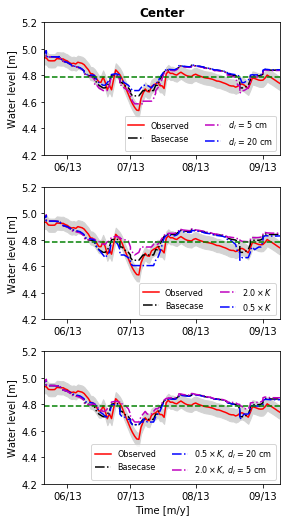

In [106]:
PlotWithCenterAverage(Perm=False)